In [1]:
import os
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import numpy as np
import itertools
from typing import List, Tuple, Optional

# create images folder
os.makedirs("images", exist_ok=True)


In [4]:

def measure_time_and_memory(func, *args, **kwargs):
    """
    Runs func(*args, **kwargs) and returns (result, elapsed_seconds, peak_memory_mb).
    Uses memory_usage to sample while running.
    """
    mem_usage = []
    def _target():
        return func(*args, **kwargs)

    start = time.perf_counter()
   
    mem_samples, retval = None, None
   
    def wrapper():
        nonlocal retval
        retval = func(*args, **kwargs)
        return retval

    mem_samples = memory_usage((wrapper, (), {}), interval=0.01, max_iterations=None, retval=False)
    end = time.perf_counter()
    elapsed = end - start
    peak_mem = max(mem_samples) - min(mem_samples) if mem_samples else 0.0
    return retval, elapsed, peak_mem


Selected slots:
1 : C
2 : A
3 : E
Total profit: 142


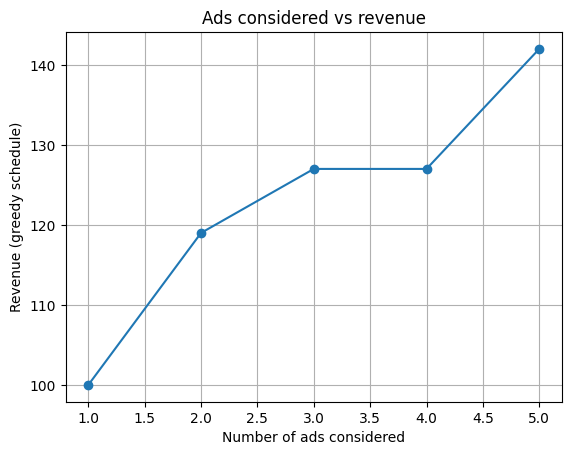

In [5]:
from dataclasses import dataclass

@dataclass
class Ad:
    id: str
    deadline: int
    profit: int

def schedule_ads_greedy(ads: List[Ad]) -> Tuple[List[Optional[Ad]], int]:
    """
    Returns (slot_list, total_profit)
    slot_list length equals max deadline; slots contain Ad or None.
    """
    if not ads:
        return [], 0
    # sort by profit descending
    ads_sorted = sorted(ads, key=lambda a: a.profit, reverse=True)
    max_deadline = max(a.deadline for a in ads_sorted)
    slots = [None] * max_deadline  # single time slot per unit time
    total = 0
    for ad in ads_sorted:
        # try to place ad at latest possible slot before deadline
        for slot in range(min(ad.deadline, max_deadline) - 1, -1, -1):
            if slots[slot] is None:
                slots[slot] = ad
                total += ad.profit
                break
    return slots, total

ads_sample = [
    Ad("A", 2, 100),
    Ad("B", 1, 19),
    Ad("C", 2, 27),
    Ad("D", 1, 25),
    Ad("E", 3, 15)
]

slots, total_profit = schedule_ads_greedy(ads_sample)
print("Selected slots:")
for i, s in enumerate(slots, start=1):
    print(i, ":", s.id if s else None)
print("Total profit:", total_profit)

def plot_ads_vs_revenue(ads):
    revenues = []
    ad_counts = list(range(1, len(ads)+1))
    for k in ad_counts:
        slots, rev = schedule_ads_greedy(ads[:k])
        revenues.append(rev)
    plt.plot(ad_counts, revenues, marker='o')
    plt.xlabel("Number of ads considered")
    plt.ylabel("Revenue (greedy schedule)")
    plt.title("Ads considered vs revenue")
    plt.grid(True)
    plt.savefig("images/ads_vs_revenue.png", bbox_inches='tight')
    plt.show()

plot_ads_vs_revenue(ads_sample)


Max profit: 220
Chosen item indices: [1, 2]


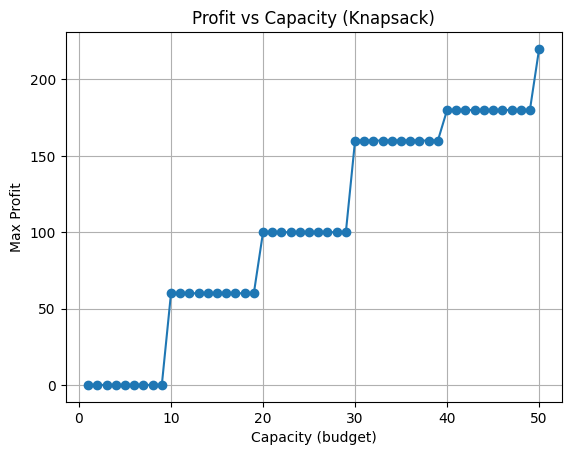

In [6]:
def knapsack_01(values: List[int], weights: List[int], capacity: int) -> Tuple[int, List[int]]:
    """
    Returns (max_value, chosen_item_indices)
    Standard bottom-up DP O(n*capacity)
    """
    n = len(values)
    dp = [[0] * (capacity + 1) for _ in range(n + 1)]
    # build table
    for i in range(1, n+1):
        v = values[i-1]
        w = weights[i-1]
        for cap in range(capacity+1):
            if w <= cap:
                dp[i][cap] = max(dp[i-1][cap], dp[i-1][cap-w] + v)
            else:
                dp[i][cap] = dp[i-1][cap]
    max_val = dp[n][capacity]
    # reconstruct items
    chosen = []
    cap = capacity
    for i in range(n, 0, -1):
        if dp[i][cap] != dp[i-1][cap]:
            chosen.append(i-1)
            cap -= weights[i-1]
    chosen.reverse()
    return max_val, chosen

values = [60, 100, 120]
weights = [10, 20, 30]
capacity = 50

res, chosen = knapsack_01(values, weights, capacity)
print("Max profit:", res)
print("Chosen item indices:", chosen)

def plot_profit_vs_capacity(values, weights, max_capacity):
    caps = list(range(1, max_capacity+1))
    profits = []
    for c in caps:
        p, _ = knapsack_01(values, weights, c)
        profits.append(p)
    plt.plot(caps, profits, marker='o')
    plt.xlabel("Capacity (budget)")
    plt.ylabel("Max Profit")
    plt.title("Profit vs Capacity (Knapsack)")
    plt.grid(True)
    plt.savefig("images/knapsack_profit_vs_capacity.png", bbox_inches='tight')
    plt.show()

plot_profit_vs_capacity(values, weights, capacity)


In [7]:
from copy import deepcopy

def find_empty(grid):
    for r in range(9):
        for c in range(9):
            if grid[r][c] == 0:
                return r, c
    return None

def valid(grid, row, col, num):
    # check row
    if any(grid[row][c] == num for c in range(9)):
        return False
    # check column
    if any(grid[r][col] == num for r in range(9)):
        return False
    # check box
    box_r = (row // 3) * 3
    box_c = (col // 3) * 3
    for r in range(box_r, box_r+3):
        for c in range(box_c, box_c+3):
            if grid[r][c] == num:
                return False
    return True

def solve_sudoku(grid):
    pos = find_empty(grid)
    if not pos:
        return True  # solved
    r, c = pos
    for num in range(1, 10):
        if valid(grid, r, c, num):
            grid[r][c] = num
            if solve_sudoku(grid):
                return True
            grid[r][c] = 0
    return False

# sample Sudoku (0 means empty)
sample = [
    [5,3,0,0,7,0,0,0,0],
    [6,0,0,1,9,5,0,0,0],
    [0,9,8,0,0,0,0,6,0],
    [8,0,0,0,6,0,0,0,3],
    [4,0,0,8,0,3,0,0,1],
    [7,0,0,0,2,0,0,0,6],
    [0,6,0,0,0,0,2,8,0],
    [0,0,0,4,1,9,0,0,5],
    [0,0,0,0,8,0,0,7,9]
]

grid = deepcopy(sample)
start = time.perf_counter()
solved = solve_sudoku(grid)
end = time.perf_counter()
print("Solved:", solved)
print("Time:", end-start)
if solved:
    for row in grid:
        print(row)

# Optional: time vs number of empty cells (simulate by making k random empties) - quick demo
import random
def time_vs_empty_cells(sample_grid, trials=5):
    empty_counts = []
    times = []
    base = np.array(sample_grid)
    filled_positions = [(r,c) for r in range(9) for c in range(9) if base[r,c] != 0]
    for k in range(1, min(40, len(filled_positions)), 5):
        tlist = []
        for _ in range(trials):
            g = base.copy()
            rem = random.sample(filled_positions.tolist(), k)
            for (r,c) in rem:
                g[r,c] = 0
            glist = g.tolist()
            st = time.perf_counter()
            solve_sudoku(glist)
            tlist.append(time.perf_counter() - st)
        empty_counts.append(k)
        times.append(sum(tlist)/len(tlist))
    plt.plot(empty_counts, times, marker='o')
    plt.xlabel("Number of forced empty cells")
    plt.ylabel("Average solve time (s)")
    plt.title("Sudoku: time vs empty cells (demo)")
    plt.grid(True)
    plt.savefig("images/sudoku_time_vs_empty.png", bbox_inches='tight')
    plt.show()

# Commented out the experimental call because it can be slow; you can enable if needed:
# time_vs_empty_cells(sample)


Solved: True
Time: 0.16164659999776632
[5, 3, 4, 6, 7, 8, 9, 1, 2]
[6, 7, 2, 1, 9, 5, 3, 4, 8]
[1, 9, 8, 3, 4, 2, 5, 6, 7]
[8, 5, 9, 7, 6, 1, 4, 2, 3]
[4, 2, 6, 8, 5, 3, 7, 9, 1]
[7, 1, 3, 9, 2, 4, 8, 5, 6]
[9, 6, 1, 5, 3, 7, 2, 8, 4]
[2, 8, 7, 4, 1, 9, 6, 3, 5]
[3, 4, 5, 2, 8, 6, 1, 7, 9]


Found: 1a Attempts: 13 Time(s): 1.8699996871873736e-05


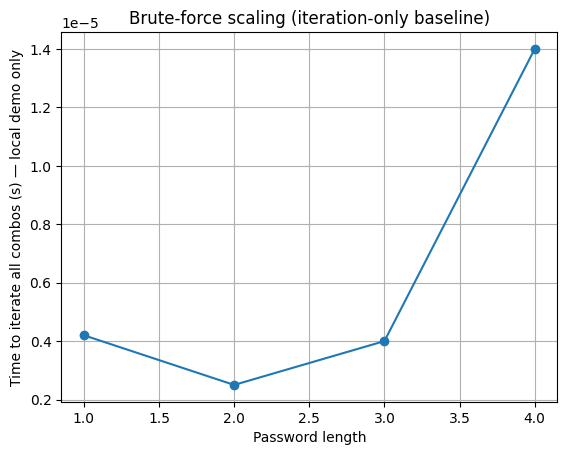

In [8]:
def brute_force_password(target: str, charset: List[str], max_len:int=5):
    attempts = 0
    start = time.perf_counter()
    for length in range(1, max_len+1):
        for combo in itertools.product(charset, repeat=length):
            attempts += 1
            attempt = ''.join(combo)
            if attempt == target:
                elapsed = time.perf_counter() - start
                return attempt, attempts, elapsed
    return None, attempts, time.perf_counter() - start

charset = list('ab12') 
target = "1a"          
found, attempts, elapsed = brute_force_password(target, charset, max_len=3)
print("Found:", found, "Attempts:", attempts, "Time(s):", elapsed)

def plot_brute_force_scaling(charset, target_prefix="a"):
    lengths = [1,2,3,4]
    times = []
    for L in lengths:
        tstart = time.perf_counter()
        count = 0
        for _ in itertools.product(charset, repeat=L):
            count += 1
        elapsed = time.perf_counter() - tstart
        times.append(elapsed)
    plt.plot(lengths, times, marker='o')
    plt.xlabel("Password length")
    plt.ylabel("Time to iterate all combos (s) — local demo only")
    plt.title("Brute-force scaling (iteration-only baseline)")
    plt.grid(True)
    plt.savefig("images/bruteforce_scaling_iteronly.png", bbox_inches='tight')
    plt.show()

plot_brute_force_scaling(charset)


In [9]:
vals = [60,100,120,80,50,70,40,30,20]
wts =  [10,20,30,15,8,12,7,6,5]
cap = 100

def run_knapsack_example():
    return knapsack_01(vals, wts, cap)

result, elapsed, peak_mem = measure_time_and_memory(run_knapsack_example)
print("Knapsack result:", result)
print(f"Elapsed: {elapsed:.4f}s, Peak mem delta: {peak_mem:.4f} MiB")


Knapsack result: (500, [0, 1, 2, 3, 5, 6, 7])
Elapsed: 2.2292s, Peak mem delta: 0.0000 MiB


In [10]:
readme_text = """
# Algo Strategies Mini Project - TEMPLATE
This repo contains implementations and profiling for:
- Greedy Job Sequencing (TV Ad Scheduling)
- 0/1 Knapsack (Dynamic Programming)
- Sudoku Solver (Backtracking)
- Password Cracking (Brute Force)

See `algo_strategies_notebook.ipynb` for code, comments, and plots.

Requirements:
- numpy, matplotlib, memory_profiler

How to run:
1. Create virtual env, install requirements, open notebook
2. Run cells in order
"""
with open("README_note.txt", "w") as f:
    f.write(readme_text)

# Create requirements.txt
with open("requirements.txt", "w") as f:
    f.write("numpy\nmatplotlib\nmemory_profiler\n")
print("Saved README_note.txt and requirements.txt")


Saved README_note.txt and requirements.txt
